## Maps

This is a JupyterLab Notebook summarizing the code I wrote to make some maps of rivers using Python and Geopandas.  But before we get to that, we should start with an outline of the general situation.

### Background

On my machines, running macOS, I have Python 3 installed via Homebrew.

It is in the default locations. For the mini, that is ``/usr/local/bin``, while on my new Macbook it is in ``/opt/homebrew/bin``.

It seems that these python installations are only used with a virtual environment.  To set one up, just ``cd`` into a convenient directory and do

`/opt/homebrew/bin/python3 -m venv maps`

That makes a virtual environment with all its supporting files stored in the `maps` directory under whatever directory you were in when you invoked this command.

I like working on the desktop so from ``~/Desktop`` do

`source ~/Programming/maps/bin/activate`

`(maps) > `

The prompt will change to `(maps) >`.

That's quite a long command.  It's easy to make an alias in `~/.zshrc` such as `alias activate="source ~/Programming/maps/bin/activate"`.  

Now that the venv is active you can do:

`(maps) > pip install --upgrade pip`

`(maps) > python -m pip install matplotlib`

`(maps) > python -m pip install geopandas`

`(maps) > python -m pip install jupyterlab`

The correct version of python (the one used to make the venv) can be called simply as ``python``.  Invoking `pip` as a module works better for me than calling it directly.

### Geopandas

Pandas is a popular Python module for working with dataframes.  

A dataframe is a table with possibly dissimilar columns.  For example, one might have rows of individual amino acids, and columns with various things like molecular weight, hydrophobicity, and so on.

A GeoDataFrame (I often call the variable ``gdf``) is a dataframe that contains, among other things, coordinates for geographical objects like polygons and line strings, which can represent state boundaries and rivers.  Geopandas is a popular Python module for working with this kind of data.

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd

We start with a geodataframe containg points along the boundaries of selected US states in the Pacific Northwest.

In [2]:
dbpath = '/Users/telliott/'
dbpath += 'Library/CloudStorage/Dropbox/data/'
fn = 'OR_WA_ID_MT_WY.shp.zip'
nw_states = gpd.read_file(dbpath + fn)

Various method exist to access the individual rows.  The 'NAME' column contains the names of states.  The 'STATE' column contains the FIPS code for each.

In [3]:
nw_states.columns

Index(['GEO_ID', 'STATE', 'NAME', 'LSAD', 'CENSUSAREA', 'geometry'], dtype='object')

In [4]:
nw_states['NAME']

0        Oregon
1    Washington
2         Idaho
3       Montana
4       Wyoming
Name: NAME, dtype: object

In [5]:
nw_states['STATE']

0    41
1    53
2    16
3    30
4    56
Name: STATE, dtype: object

In [6]:
result = nw_states[['STATE','NAME']]
result

STATE        NAME
0    41      Oregon
1    53  Washington
2    16       Idaho
3    30     Montana
4    56     Wyoming

The code in the cell above appears to access multiple columns.  What it really does in addition is to construct and return a new GeoDataFrame.

The 'geometry' column contains objects representing the state outlines as POLYGON or MULTIPOLYGON objects.  Washington is a MULTIPOLYGON because it includes a number of islands.

In [7]:
nw_states['geometry']

0    POLYGON ((-121.92224 45.64908, -121.90827 45.6...
1    MULTIPOLYGON (((-122.51953 48.28831, -122.5227...
2    POLYGON ((-111.04416 43.02005, -111.04413 43.0...
3    POLYGON ((-105.0384 45.00034, -105.07661 45.00...
4    POLYGON ((-110.04848 40.99755, -110.12164 40.9...
Name: geometry, dtype: geometry

This dataframe has already been filtered from a larger one containing all 50 states plus DC and Puerto Rico.  Let's load the larger one and showing how to obtain what we have above.

In [8]:
fn='gz_2010_us_040_00_5m.zip'
gdf = gpd.read_file(dbpath + fn)
print(gdf.shape)

(52, 6)


So 52 entries as rows, and each with 6 columns of attributes.  The states we want to select are:  OR, WA, ID, MT, WY.  Here is one way to do it.

In [9]:
L = ['Oregon','Washington','Idaho',
     'Montana','Wyoming']
sel = gdf['NAME'].isin(L)

In [10]:
sub = gdf[sel]
print(sub.shape)

(5, 6)


The ``sel`` variable is a series of boolean values.  The code is otherwise straightforward except for the use of ``isin``, which isn't standard Python but a Pandas thing.

In [11]:
sel.iloc[10:14]

10    False
11    False
12     True
13    False
Name: NAME, dtype: bool

``gdf[sel]`` filters for rows with a value of ``True``.

``iloc`` is a Pandas way of indexing by a numerical index.  It is distinguished from ``loc``, which uses labels.

### ``apply``

Another way to do the same thing is to supply a named function, or more Pythonically, a ``lambda`` expression.

In [12]:
sel = gdf['NAME'].apply(lambda r: r in L)
sub = gdf[sel]
print(gdf.shape, sub.shape)

(52, 6) (5, 6)


And yet a third way is to construct a series of logical expressions.

In [13]:
OR = gdf['NAME'] == 'Oregon'
WA = gdf['NAME'] == 'Washington'
ID = gdf['NAME'] == 'Idaho'
MT = gdf['NAME'] == 'Montana'
WY = gdf['NAME'] == 'Wyoming'
sub = gdf[OR | WA | ID | MT | WY]
print(gdf.shape, sub.shape)

(52, 6) (5, 6)


Since we have ``matplotlib``, let's plot the data.  A simple approach is:

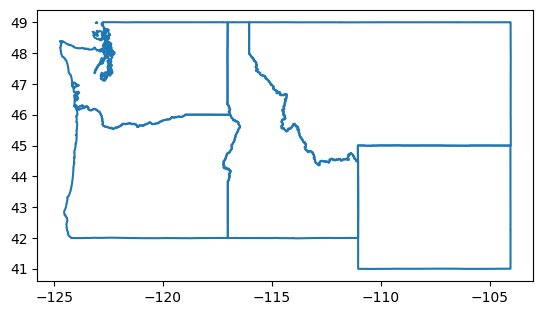

In [14]:
nw_states.boundary.plot()
plt.show()

To save the plot to a file

In [15]:
ofn = 'example.png'
plt.savefig(ofn,dpi=300)

<Figure size 640x480 with 0 Axes>

It would be nice to have some labels. Let's add a column to the data with the two letter abbreviations.

In [16]:
L = ['OR','WA','ID','MT','WY']
nw_states = nw_states.assign(abbrev = L)
nw_states['abbrev']

0    OR
1    WA
2    ID
3    MT
4    WY
Name: abbrev, dtype: object

In [17]:
def f(e):
    return e.representative_point().coords[:][0]

The ``[0]`` at the end is because the coordinates are like ``[(x,y)]``.

In [18]:
nw_states['coords'] = nw_states['geometry'].apply(f)
nw_states['coords']

0    (-120.51490187597771, 44.139333893360046)
1      (-119.73301862372591, 47.2734280475521)
2    (-115.46324561457074, 45.494265999999996)
3    (-109.34110685676336, 46.681627999999996)
4             (-107.54854862632588, 42.987824)
Name: coords, dtype: object

One can use ``iterrows`` to iterate through the data.  We adjust the position of the label for Idaho.

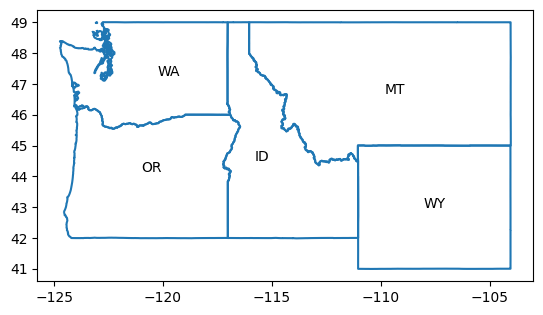

In [19]:
nw_states.boundary.plot()
for i,row in nw_states.iterrows():
    x,y = row['coords']
    if row['NAME'] == 'Idaho':
        y -= 1
    plt.annotate(text=row['abbrev'],
        xy=(x,y),
        horizontalalignment='center')

plt.show()

Let's add a river.  The original data is in a file named 'North_America_Lakes_and_Rivers.zip'.  I have filtered the data to retain only the rivers in the Pacific Northwest.

In [20]:
fn = 'nw_rivers.shp.zip'
nw_rivers = gpd.read_file(dbpath + fn)

It's important to match the coordinate representation system (CRS) for `nw_states` and `nw_rivers`.  The code shows they are already matched, so the `to_crs` call isn't really necessary.

In [21]:
print(nw_states.crs)
print(nw_rivers.crs)
mycrs = nw_rivers.crs
nw_states.to_crs(mycrs,inplace=True)

EPSG:4269
EPSG:4269


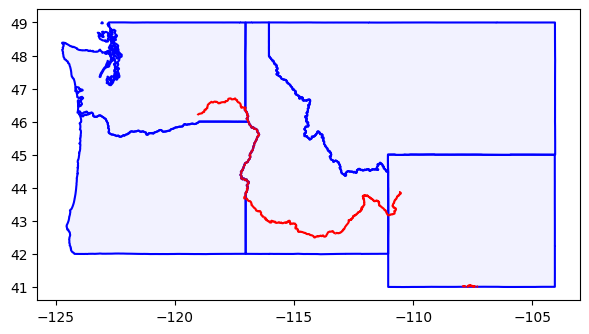

In [22]:
def sel(s):
    return nw_rivers['NameEn'].str.contains(s)

Snake = nw_rivers[sel('Snake')]

# remove some small waterways
Snake = Snake[Snake['LengthKm'] > 200]

ax = nw_states.boundary.plot(
    figsize=(7,7),color='blue')
nw_states.plot(ax=ax,color='b',alpha=0.05)
Snake.plot(ax=ax,color='red')
plt.savefig('snake.png',dpi=300)

There is one more item to be cleaned up --- the small object at the bottom of Wyoming.

In [23]:
Snake['NameEn']

1220    Little Snake River
1275           Snake River
1276           Snake River
1277           Snake River
1278           Snake River
Name: NameEn, dtype: object

In [24]:
t = 'Little Snake River'
Snake = Snake[Snake['NameEn'] != t]

In [25]:
Snake['NameEn']

1275    Snake River
1276    Snake River
1277    Snake River
1278    Snake River
Name: NameEn, dtype: object

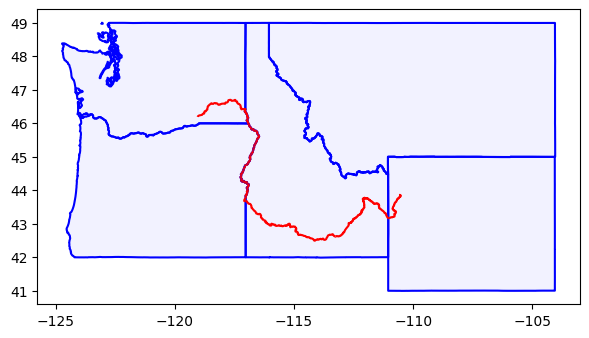

In [26]:
ax = nw_states.boundary.plot(
    figsize=(7,7),color='blue')
nw_states.plot(ax=ax,color='b',alpha=0.05)
Snake.plot(ax=ax,color='red')
plt.show()

Note:  the original rivers data is quite a large file.  I filtered it for data in a restricted geographic region and then saved it as a shapefile.

In [27]:
fn = 'North_America_Lakes_and_Rivers.zip'
na_rivers = gpd.read_file(dbpath + fn)
na_rivers = na_rivers.to_crs(mycrs)
nw_rivers = na_rivers.overlay(nw_states, 
    how='intersection')

nw_rivers.to_file(
    filename='nw_rivers.shp.zip',
    driver='ESRI Shapefile')


In [28]:
na_rivers.shape

(5811, 7)

In [29]:
nw_rivers.shape

(492, 14)

In [30]:
nw_rivers.columns

Index(['FID', 'Country', 'NameEn', 'NameEs', 'NameFr', 'LengthKm', 'GEO_ID',
       'STATE', 'NAME', 'LSAD', 'CENSUSAREA', 'abbrev', 'coords', 'geometry'],
      dtype='object')

I've picked up some extra columns.  I think this happened because I included rivers in British Columbia and Alberta, although we aren't plotting them.

This is a figure annotated using a separate application (Keynote).

<img src='annotated.png' width='600' height='300' />

Various basemaps are available with `contextily`.  Sometimes, the basemap call doesn't work, with a complaint about the zoom level.  I haven't figured that out yet.

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

dbpath = '/Users/telliott/Library/CloudStorage/Dropbox/data/'
fn = 'OR_WA_ID_MT_WY.shp.zip'
gdf = gpd.read_file(dbpath+fn)
ID = gdf[gdf['NAME'] == 'Idaho']
ax=ID.boundary.plot(color='b',figsize=(6,6))
cx.add_basemap(ax,source =cx.providers.OpenTopoMap,crs=ID.crs)
plt.show()


You do have to match the CRS or change (warp) it for the basemap.

The code below illustrates the use of a bounding box and the `.cx` method of a gdf.  I've followed the convention for contextily and imported the name as `cx`, even though this could be confusing.  Since the method is qualified, Python keeps it all straight.

In [ ]:
ax=gdf.boundary.plot()

fn = 'nw_rivers.shp.zip'
nw_rivers = gpd.read_file(dbpath + fn)
nw_rivers = nw_rivers.to_crs('EPSG:4269')

# restrict the rivers to a bounding box
xmin, ymin, xmax, ymax = -116, 44, -112, 48
from shapely.geometry import Polygon
poly = Polygon([(xmin,ymin),(xmax,ymin),(xmax,ymax),(xmin,ymax)])
gs = gpd.GeoSeries(poly)
bbox = gpd.GeoDataFrame({'geometry': gs})
bbox = bbox.set_crs('EPSG:4269')
sub = nw_rivers.overlay(bbox, how='intersection')

# continental divide
fn = 'Continental_Divide-Pacific_Atlantic.zip'
cdiv = gpd.read_file(dbpath + fn)
cdiv = cdiv.to_crs('EPSG:4269')
cdiv = cdiv.overlay(gdf, how='intersection')

cdiv.plot(ax=ax,color='r')
bbox.boundary.plot(ax=ax,color='gray')
sub.plot(ax=ax,color='b',lw=0.6)

plt.show()

The red line is the continental divide.  This makes it easier to understand which way the rivers must flow.

### Notes about the Jupyter notebook.

To convert this notebook to html do:

`jupyter nbconvert --execute --to html explore.ipynb`

One can print directly to a pdf, but I found the font is too big. (This may be because I have the font set large in Safari so I can read it easily). Saving to html and then printing that seems to work OK.

As the notebook got larger, scrolling to a cell in the middle became impossible.  From the web, the fix was

“Settings → Settings Editor → Notebook → Windowing mode → none”

which solved the problem.